# 一次元CNNの時系列解析

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## とりあえずダミーデータ作成

#### これはノイズ除去用

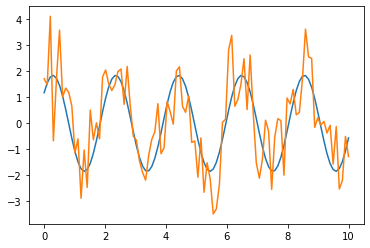

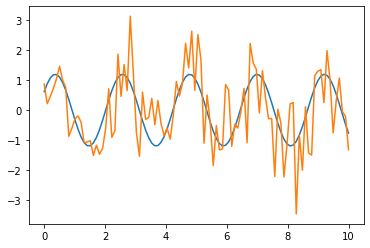

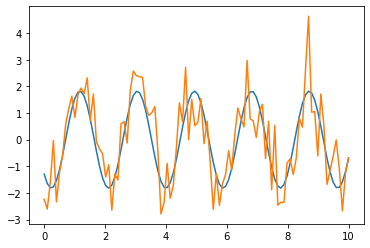

In [5]:
n_sample = 10000                           #作るサンプル数の指定
data_length = 100                          #作る時系列データの大きさ指定
time = 10                                  #作る時系列データの長さ指定

t = np.linspace(0,time,data_length)        #基準の時間軸生成
T = 1 + np.random.random((n_sample,1))*2   #時定数(周波数の逆数)を決める(T=[1,3))
A = 1 + np.random.random((n_sample,1))     #振幅(A=[1,2))
_x = np.random.randn(n_sample,1)           #sin波平行移動用
y = A*np.sin((2*np.pi / T)*t.reshape(1,data_length) + _x)    #sin波を適当にn_sample作成(n_sample,data_length)
d = np.random.randn(n_sample, data_length) #外乱生成
y_origin = y        #教師データ
y_noise = y + d     #ノイズデータ

#プロット
for i in range(3):
    plt.plot(t,y_origin[i])
    plt.plot(t,y_noise[i])
    plt.show()

## 訓練データとテストデータに分ける

In [5]:
X_train, X_test, y_train, y_test = train_test_split(y_noise,y_origin)
print("X_train => ",X_train.shape)
print("X_train => ",y_train.shape)
print("X_test => ",X_test.shape)
print("y_test => ",y_test.shape)


X_train_cnn = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_cnn  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train.shape)
print(X_test.shape)

X_train =>  (7500, 100)
X_train =>  (7500, 100)
X_test =>  (2500, 100)
y_test =>  (2500, 100)
(7500, 100)
(2500, 100)


## 必要そうなクラスや関数リストをまとめておく

**最低限必要なLayer Class**
- 畳み込み層(Conv1d)
- 平滑化層(Flatten)
- 全結合出力層(Affin)
 - 回帰
 - 二値分類
 - 多値分類
- Pooling層

あればうれしい
- 全結合中間層(全結合出力層で一緒に作れる)
- Atrous層

### Optimizerのクラス群
- SGD
- Adagrad

発展的なOptimizer
- Adam
- Eve
- 最近提案されたやつ(Adaboundsとか？)

## 実装していく

## 活性化関数の実装

活性化関数は畳み込み層や全結合層のforward/backward両方で使われるため、それより先に作る必要がある。


In [ ]:
class ReLu:
    def __init__(self):
        pass
    
    def forward(self,X):
        
        pass
    
    def backward(self,Y)

## Conv1D Layer

入力は一般で X( batch_size, ch_in, data_size ) ですが分りやすいように X( 1, 1, 100 ) とします。  
フィルタ W( ch_size, filter_size ) が W( 2, 3 ) の時(Paddingがなければ)、出力 Y( batch_size, ch_out, output_size ) は Y( 1, 2, 98 ) です。

Forward Propagation と Back Propagationを 簡単に実験しましょう。（余裕という人は飛ばして実装するといいと思います）

In [6]:
#w,b等は__init__()メソッドで初期化するのでインスタンス変数が保有している（と考える）
#パディングの大きさ、ストライドの広さも持っている（と考える）
def forward(X):
    """
    X(入力)      :( batch_size, ch_in, data_size )
    W(フィルタ)  :( ch_out, filter_size )
    b(バイアス)　:( ch_out )
    S(ストライド):( 1 )#int <= 2Dだとまた違う
    P(パディング):( 1 )#int <= 2Dだとまた違う

    Y(出力)      :( batch_size, ch_size, (data_size + 2*P - filter_size) // S + 1 )
    """
    
    
    
    return Y

In [ ]:
#forwardでの出力Yを持っておかないと計算できないので、クラスで設計するときはインスタンス変数に渡して、backward()メソッドでも使えるようにしておく
def backward(Y,dY):
    """
    dY(後ろからの入力) :( batch_size, ch_size, (data_size + 2*P - filter_size) // S + 1 )
    W(フィルタ)        :( ch_out, filter_size )
    b(バイアス)　      :( ch_out )
    S(ストライド)      :( 1 )#int
    P(パディング)      :( 1 )#int

    dX(前の層への出力) :( batch_size, ch_in, data_size )
    """
    
    
    
    return dX

理想的に抽象度高く実装する場合


レイヤーはクラスで設計して、それぞれforward/backwardメソッドを持たせておくことで、アーキテクチャ全体を設計するクラス（別に作る）で統一的に呼び出せるようにする。
レイヤーが呼び出された時点で初期値を設定したいので、レイヤークラスの__init__()メソッドで初期化する。

**optimizerとの関係**  
optimizeは層の設定時に決定したいので、引数にoptimizerのクラスオブジェクトをそのまま渡す。
この辺りは細かい設計の問題だと思うが、optimizer内でパラメータを最適化していくため、optimizerでそれぞれのパラメータを初期化するのがいいと思う。ただし、入力の形状を使ってパラメータを初期化するはずなので、optimizerをクラスのインスタンス生成後（中）にパラメータを生成しないといけない。具体的には
```
Conv1D(in_shape=(1,100),out_shape=(2, 98),kernel=3,alpha=0.01, activation=LeakyReLU(a=0.), optimizer=Adagrad())
```

こんな風に書けるといいと思う